# Main Runner

## Imports

In [1]:
import pandas as pd
from objects import *
import pickle
import os
import matplotlib.pyplot as plt

import plotly.express as px

## Generate Experiments

In [2]:
# prices = pd.read_parquet("raw_data/spx_stock_prices.parquet")
# treasury_rate_files = ["daily-treasury-rates.csv"] + [f"daily-treasury-rates ({i}).csv" for i in range(1, 25)]
# rates_df = [pd.read_csv(f"raw_data/{file}", index_col=0) for file in treasury_rate_files]
# rates_df = pd.concat(rates_df)
# rates_df.index = pd.to_datetime(rates_df.index)
# # sort rates_df by date
# rates_df = rates_df.sort_index()
# print("Start Generation")
# generate_experiments(prices, rates_df, 250, "experiments", lookback=48, error_max=10)

# Read in generated experiments

In [2]:
# Get all files in the experiments folder
experiment_names = os.listdir('experiments')
experiments = []
# read in pickle object
for e in experiment_names:
    with open(f"experiments/{e}", 'rb') as f:
        exp = pickle.load(f)
        experiments.append(exp)

In [3]:
experiment_names = os.listdir('experiments')
with open(f"experiments/{experiment_names[0]}", 'rb') as f:
    exp = pickle.load(f)
policy = DirectionalIncentiveTradingPolicy(exp)
simulator = MarketSimulator(exp, policy)
simulator.run()

Starting Simulation


  0%|          | 0/31 [00:00<?, ?it/s]

Current Portfolio Value at 2021-07-29: 103007.0
	 Optimizing with 31 time steps, 1911 constraints, and 2480 variables...
	 Optimized. Time taken: 0.08761978149414062


  3%|▎         | 1/31 [00:00<00:19,  1.58it/s]

Current Portfolio Value at 2021-07-30: 102275.46998063239
	 Optimizing with 30 time steps, 1850 constraints, and 2400 variables...
	 Optimized. Time taken: 0.08854389190673828


  6%|▋         | 2/31 [00:01<00:17,  1.64it/s]

Current Portfolio Value at 2021-08-02: 101732.6399731037
	 Optimizing with 29 time steps, 1789 constraints, and 2320 variables...
	 Optimized. Time taken: 0.07812070846557617


 10%|▉         | 3/31 [00:01<00:16,  1.70it/s]

Current Portfolio Value at 2021-08-03: 102765.94997310369
	 Optimizing with 28 time steps, 1728 constraints, and 2240 variables...
	 Optimized. Time taken: 0.07952761650085449


 13%|█▎        | 4/31 [00:02<00:15,  1.72it/s]

Current Portfolio Value at 2021-08-04: 101570.25997310369
	 Optimizing with 27 time steps, 1667 constraints, and 2160 variables...


 16%|█▌        | 5/31 [00:02<00:15,  1.71it/s]

	 Optimized. Time taken: 0.11451220512390137
Current Portfolio Value at 2021-08-05: 102572.77997220776
	 Optimizing with 26 time steps, 1606 constraints, and 2080 variables...
	 Optimized. Time taken: 0.11661314964294434


 19%|█▉        | 6/31 [00:03<00:14,  1.70it/s]

Current Portfolio Value at 2021-08-06: 103233.02996818136
	 Optimizing with 25 time steps, 1545 constraints, and 2000 variables...
	 Optimized. Time taken: 0.14652800559997559


 23%|██▎       | 7/31 [00:04<00:14,  1.68it/s]

Current Portfolio Value at 2021-08-09: 103111.51996818135
	 Optimizing with 24 time steps, 1484 constraints, and 1920 variables...
	 Optimized. Time taken: 0.09952402114868164


 26%|██▌       | 8/31 [00:04<00:13,  1.72it/s]

Current Portfolio Value at 2021-08-10: 104137.58996818136
	 Optimizing with 23 time steps, 1423 constraints, and 1840 variables...
	 Optimized. Time taken: 0.0655508041381836


 29%|██▉       | 9/31 [00:05<00:12,  1.79it/s]

Current Portfolio Value at 2021-08-11: 105394.07996280385
	 Optimizing with 22 time steps, 1362 constraints, and 1760 variables...
	 Optimized. Time taken: 0.046514272689819336


 32%|███▏      | 10/31 [00:05<00:11,  1.86it/s]

Current Portfolio Value at 2021-08-12: 105323.96996280385
	 Optimizing with 21 time steps, 1301 constraints, and 1680 variables...
	 Optimized. Time taken: 0.07666754722595215


 35%|███▌      | 11/31 [00:06<00:10,  1.90it/s]

Current Portfolio Value at 2021-08-13: 104994.65996280385
	 Optimizing with 20 time steps, 1240 constraints, and 1600 variables...
	 Optimized. Time taken: 0.1366574764251709


 39%|███▊      | 12/31 [00:06<00:10,  1.86it/s]

Current Portfolio Value at 2021-08-16: 104927.66996280385
	 Optimizing with 19 time steps, 1179 constraints, and 1520 variables...
	 Optimized. Time taken: 0.06800317764282227


 42%|████▏     | 13/31 [00:07<00:09,  1.89it/s]

Current Portfolio Value at 2021-08-17: 103869.17995913465
	 Optimizing with 18 time steps, 1118 constraints, and 1440 variables...
	 Optimized. Time taken: 0.06899333000183105


 45%|████▌     | 14/31 [00:07<00:08,  1.95it/s]

Current Portfolio Value at 2021-08-18: 102895.67995913465
	 Optimizing with 17 time steps, 1057 constraints, and 1360 variables...


 48%|████▊     | 15/31 [00:08<00:09,  1.76it/s]

	 Optimized. Time taken: 0.29982614517211914
Current Portfolio Value at 2021-08-19: 102090.64995913465
	 Optimizing with 16 time steps, 996 constraints, and 1280 variables...
	 Optimized. Time taken: 0.06950759887695312


 52%|█████▏    | 16/31 [00:08<00:08,  1.86it/s]

Current Portfolio Value at 2021-08-20: 102887.03995831186
	 Optimizing with 15 time steps, 935 constraints, and 1200 variables...
	 Optimized. Time taken: 0.0570826530456543


 55%|█████▍    | 17/31 [00:09<00:07,  1.95it/s]

Current Portfolio Value at 2021-08-23: 103925.07995831186
	 Optimizing with 14 time steps, 874 constraints, and 1120 variables...
	 Optimized. Time taken: 0.07409262657165527


 58%|█████▊    | 18/31 [00:09<00:06,  2.02it/s]

Current Portfolio Value at 2021-08-24: 104624.04995831185
	 Optimizing with 13 time steps, 813 constraints, and 1040 variables...
	 Optimized. Time taken: 0.07815074920654297


 61%|██████▏   | 19/31 [00:10<00:05,  2.06it/s]

Current Portfolio Value at 2021-08-25: 105345.9899405148
	 Optimizing with 12 time steps, 752 constraints, and 960 variables...
	 Optimized. Time taken: 0.057672739028930664


 65%|██████▍   | 20/31 [00:10<00:05,  2.10it/s]

Current Portfolio Value at 2021-08-26: 104588.85994051481
	 Optimizing with 11 time steps, 691 constraints, and 880 variables...
	 Optimized. Time taken: 0.03206181526184082


 68%|██████▊   | 21/31 [00:11<00:04,  2.19it/s]

Current Portfolio Value at 2021-08-27: 105851.0199405148
	 Optimizing with 10 time steps, 630 constraints, and 800 variables...
	 Optimized. Time taken: 0.03300046920776367


 71%|███████   | 22/31 [00:11<00:03,  2.28it/s]

Current Portfolio Value at 2021-08-30: 105149.1999405148
	 Optimizing with 9 time steps, 569 constraints, and 720 variables...
	 Optimized. Time taken: 0.02435612678527832


 74%|███████▍  | 23/31 [00:11<00:03,  2.37it/s]

Current Portfolio Value at 2021-08-31: 105209.33994051481
	 Optimizing with 8 time steps, 508 constraints, and 640 variables...
	 Optimized. Time taken: 0.020589113235473633


 77%|███████▋  | 24/31 [00:12<00:02,  2.46it/s]

Current Portfolio Value at 2021-09-01: 104969.78994051482
	 Optimizing with 7 time steps, 447 constraints, and 560 variables...
	 Optimized. Time taken: 0.01541757583618164


 81%|████████  | 25/31 [00:12<00:02,  2.54it/s]

Current Portfolio Value at 2021-09-02: 105775.22994051481
	 Optimizing with 6 time steps, 386 constraints, and 480 variables...
	 Optimized. Time taken: 0.019006967544555664


 84%|████████▍ | 26/31 [00:13<00:01,  2.59it/s]

Current Portfolio Value at 2021-09-03: 105373.60994051481
	 Optimizing with 5 time steps, 325 constraints, and 400 variables...
	 Optimized. Time taken: 0.01251673698425293


 87%|████████▋ | 27/31 [00:13<00:01,  2.66it/s]

Current Portfolio Value at 2021-09-06: 105373.60994051481
	 Optimizing with 4 time steps, 264 constraints, and 320 variables...
	 Optimized. Time taken: 0.012319326400756836


 90%|█████████ | 28/31 [00:13<00:01,  2.71it/s]

Current Portfolio Value at 2021-09-07: 104110.22993267604
	 Optimizing with 3 time steps, 203 constraints, and 240 variables...
	 Optimized. Time taken: 0.00600123405456543


 94%|█████████▎| 29/31 [00:14<00:00,  2.83it/s]

Current Portfolio Value at 2021-09-08: 103857.5099326088
	 Optimizing with 2 time steps, 142 constraints, and 160 variables...
	 Optimized. Time taken: 0.0039937496185302734


 97%|█████████▋| 30/31 [00:14<00:00,  2.93it/s]

Current Portfolio Value at 2021-09-09: 103981.1899326088
	 Optimizing with 1 time steps, 81 constraints, and 80 variables...
	 Optimized. Time taken: 0.004262685775756836


100%|██████████| 31/31 [00:14<00:00,  2.11it/s]


CTSH_86158    32.000000
VMC_15202     56.000000
LNC_49015     24.000000
AME_85257     55.000000
C_70519        0.000000
J_52329       66.000000
EXC_21776     63.000000
PGR_64390     46.000000
UAL_91103     58.000000
EMR_22103     66.000000
MO_13901      59.000000
ACN_89071     64.000000
PBCT_12073    54.000000
BA_19561      44.000000
NEM_21207     50.000000
MOS_90386     63.000000
LKQ_89866     51.000000
BKR_75034     62.000000
DTE_11674     45.000000
AVY_44601     34.000000
cash           4.259933
dtype: float64

## Evaluate Policies

In [ ]:
multi_sim = MultiSimRunner('experiments', [NAIVE, DAY_TRADING, DIRECTIONAL_TRADING], trim = 141 + 70)
multi_sim.run(save_file="naive_vs_daytrading_vs_directional2.csv")

In [ ]:
exp = experiments[24]
policy = DirectionalIncentiveTradingPolicy(exp)
simulator = MarketSimulator(exp, policy)
simulator.run()

In [11]:
df = pd.concat([exp.initial_portfolio, simulator.current_portfolio, exp.final_portfolio], axis=1)
df

,2018-04-26 00:00:00,0,1
JPM_47896,125.00,0.000000,123.0
CA_25778,139.00,0.000000,106.0
IP_21573,124.00,0.000000,115.0
ORLY_79103,100.00,0.000000,103.0
AMT_86111,80.00,0.000000,124.0
CMI_41080,117.00,0.000000,125.0
CB_79057,132.00,0.000000,120.0
HRB_49373,126.00,0.000000,104.0
GD_12052,25.00,0.000000,82.0
OKE_25232,137.00,0.000000,116.0


<Axes: xlabel='date'>

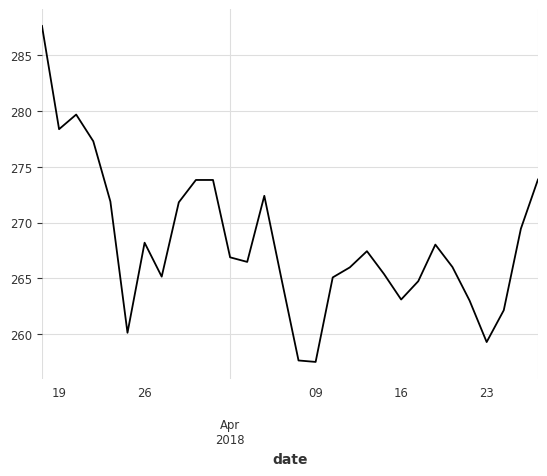

In [13]:
exp.truth['BIIB_76841'].plot()

<Axes: xlabel='date'>

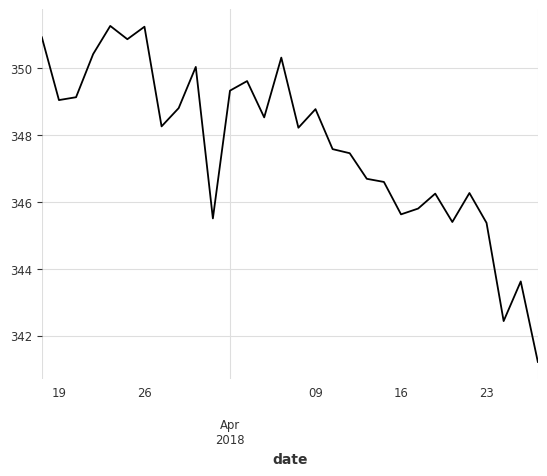

In [22]:
exp.forecasts[0]['BIIB_76841'].plot()

In [14]:
px.line(simulator.historical_portfolios)

In [15]:
px.line(simulator.historical_trades)